# Gradient Descent and Linear Regression

In this notebook, we'll explore how gradient descent can help us find the coefficients for a regression line. This is intended to be a more intuitive way to think about finding the appropriate coefficients for a line than the algorithm that R uses, which we didn't learn about in intro stat.

In [41]:
# Import block
%matplotlib notebook 

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
from sklearn import linear_model

import numpy as np
import pandas as pd

## Intuition for Gradient Descent

Suppose we are trying to find the coefficients of a simple line of the form y = mx + b, where m is the slope coefficient and b is the y-intercept. We could start by initializing our values of m and b to some random values. What we can then do is test how well these values of m and b perform for predicting our response variable. We can do this using the mean-squared error (MSE). 

The mean-squared error is the average of (the true values - the predicted values) squared, which is basically just summing up the squared residuals and dividing by the number of residuals. We can code this like so:

In [42]:
def compute_mse(truth_vec, predict_vec):
    return np.mean((truth_vec - predict_vec)**2)

Say we attempted to fit a line using these values of m and b. To assess it's fit, we'd first compute the predicted value for each one of our explanatory variable datapoints. Then we could use the MSE to assess how wrong these predicted values are from the actual corresponding response variable values for these points. If our data is reasonably correlated, then a line with a slope and intercept of zero would probably fit poorly and we'd get a high MSE. So, what if we incremented b by 1? Does the fit of our line improve? We could again compute the MSE for this line with a new b value and assess the goodness of fit. We could keep doing this process of adjusting values of m, b, or both m and b, and assessing the goodness of fit of the resulting line using the MSE. This would be exhaustive for us as humans to do, but computers can do this quite fast. 

We can think of this process as creating a grid of all the values of m and b that we want to try and computing the MSE for each one of these combinations of m and b. We can then look for the lowest MSE to find the best values of m and b. This is called grid search.

<table>
<thead>
<tr>
    <th></th>
<th>m = 0</th>
    <th>m = 0.5</th>
    <th>m = 1.5</th>
    <th>m = 2</th>
    <th>...</th>
</tr>
</thead>
<tbody>
<tr>
<th>b = 0</th>
    <td>(0,0) </td>
    <td>(0,0.5)</td>
    <td>(0,1.5) </td>
    <td>(0,2)</td>
    <td>(0,...) </td>
</tr>
<tr>
<th>b = 1/3</th>
    <td>(1/3,0) </td>
    <td>(1/3,0.5)</td>
    <td>(1/3,1.5) </td>
    <td>(1/3,2)</td>
    <td>(1/3,...) </td>
</tr>
<tr>
<th>b = 2/3</th>
    <td>(2/3,0) </td>
    <td>(2/3,0.5)</td>
    <td>(2/3,1.5) </td>
    <td>(2/3,2)</td>
    <td>(2/3,...) </td>
</tr>
<tr>
<th>b = 1</th>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
</tr>
<tr>
<th>b = 4/3</th>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
</tr>
</tbody>
</table>

_Note: This figure is originally from Lab 09 in Katherine Kinnaird's Spring 2021 machine learning class (CSC 294)_

We can actually create a grid like this, which we'll do below using some variables from the babies data set, which is discussed in more detail in the first notebook of this portfolio ("Linear Regression and Cross-Validation"). For this grid, we'll be using the gestation (explanatory) and birth weight (response) variables from the babies dataset.

In [43]:
# Prepare the data
babies_wrangled = pd.read_csv("babies_wrangled.csv")

# For regular gradient descent
gestation = babies_wrangled[["gestation"]].to_numpy()
weight = babies_wrangled[["wt"]].to_numpy()

# For stochastic gradient descent
babies_gw = babies_wrangled.loc[:, ["gestation", "wt"]].to_numpy()

babies_wrangled

,gestation,race,age,smoke,wt
0,284,4,27,0,120
1,282,0,33,0,113
2,279,0,28,1,128
3,282,0,23,1,108
4,286,0,25,2,136
...,...,...,...,...,...
1205,275,0,27,0,113
1206,265,0,24,0,128
1207,291,0,30,1,130
1208,281,0,21,0,125


We can visualize the relationship between gestation and birthweight using the scatterplot below:

<IPython.core.display.Javascript object>


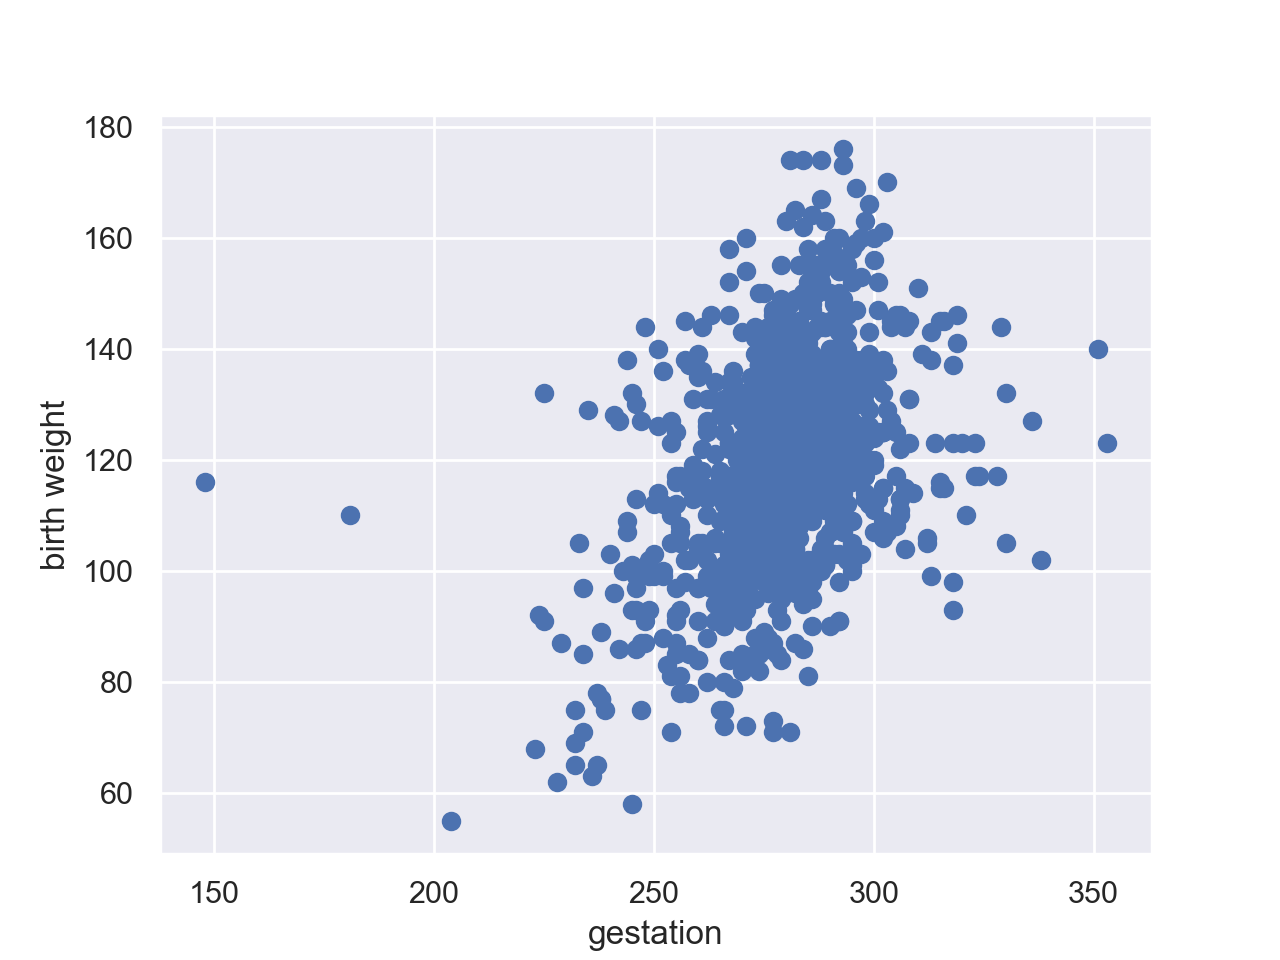

Text(0, 0.5, 'birth weight')

In [45]:
# Plot gestation and birth weight
plt.scatter(gestation, weight)
plt.xlabel("gestation")
plt.ylabel("birth weight")

NOTE: Please turn off plots using the power button in the top right corner or weird things will happen when trying to run later code/plots

In [46]:
## Code originally from CSC 294 Spring 2021 Lab 9
## This is where we create our grid

# Set the possible values for our parameters
m_vec = np.arange(-10, 10, 0.1)
b_vec = np.arange(-20, 20, 0.2)

# Create a place to store the values 
# HINT - Look at the above matrix! 
eval_mat = np.zeros([len(m_vec),len(b_vec)])

# Try (or loop) over all possible combinations
# HINT think about how you would traverse this grid
for m_inds in range(len(m_vec)):
    m = m_vec[m_inds]
    for b_inds in range(len(b_vec)):
        b = b_vec[b_inds]
        preds = m*gestation + b
        goodness = compute_mse(weight,preds)
        eval_mat[m_inds,b_inds] = goodness

There is a function that the matplotlib package contains called imshow(), which can visually represent the values in a matrix by mapping colors to them. Below we can see how imshow() interprets the grid we just made:

<IPython.core.display.Javascript object>


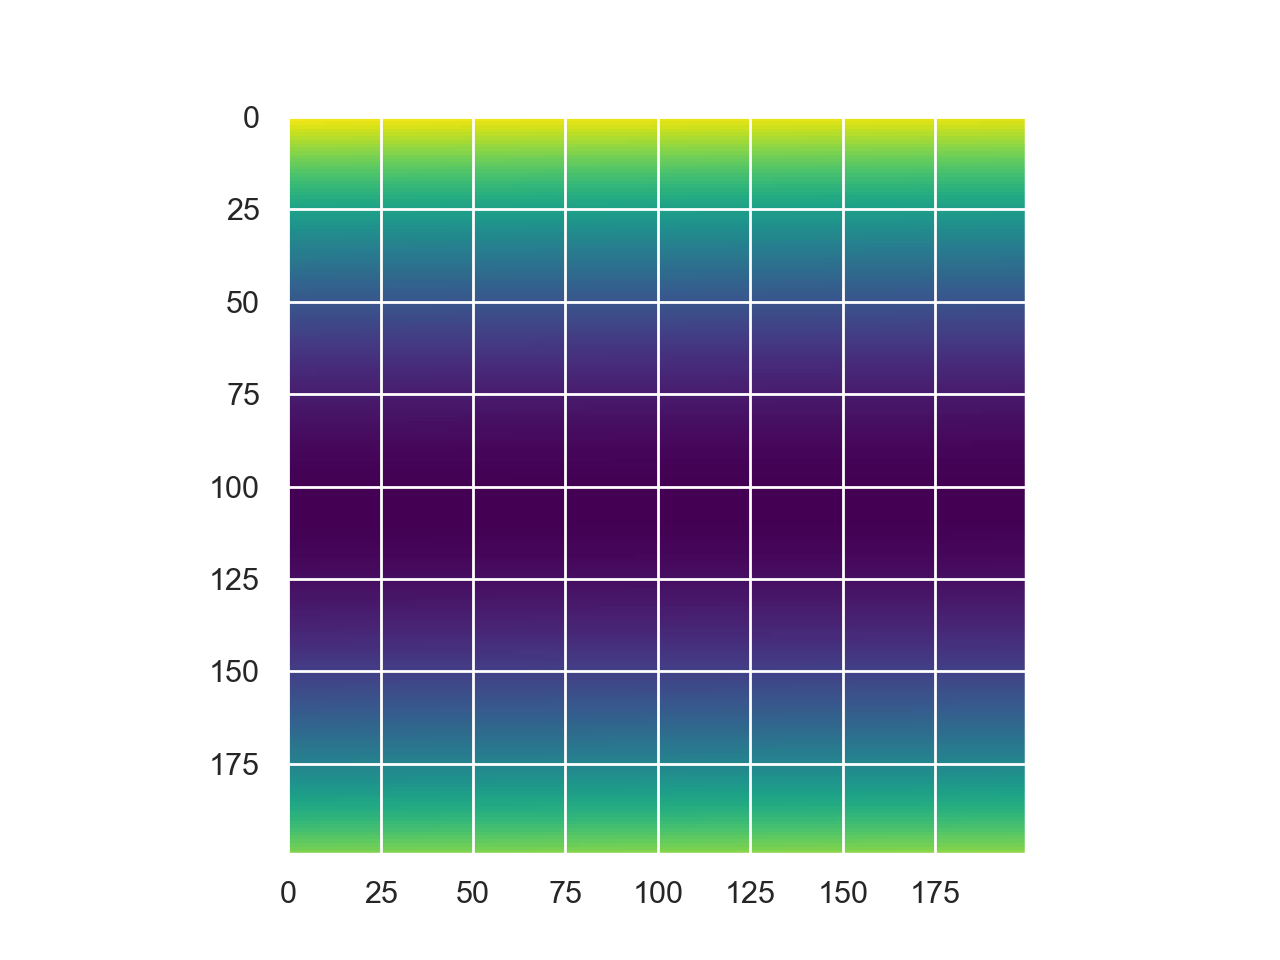

In [47]:
plt.imshow(eval_mat,cmap='viridis')

Okay so how can we find the lowest MSE in this grid? One way is that we can turn this grid into a three-dimensional surface and try to find the lowest point on that surface. This is essentially what gradient descent attempts to do. To turn this grid into a three dimensional surface, we can create a space in which we plot the value for m, the value for b, and the associated MSE, with MSE on the vertical axis.

<IPython.core.display.Javascript object>


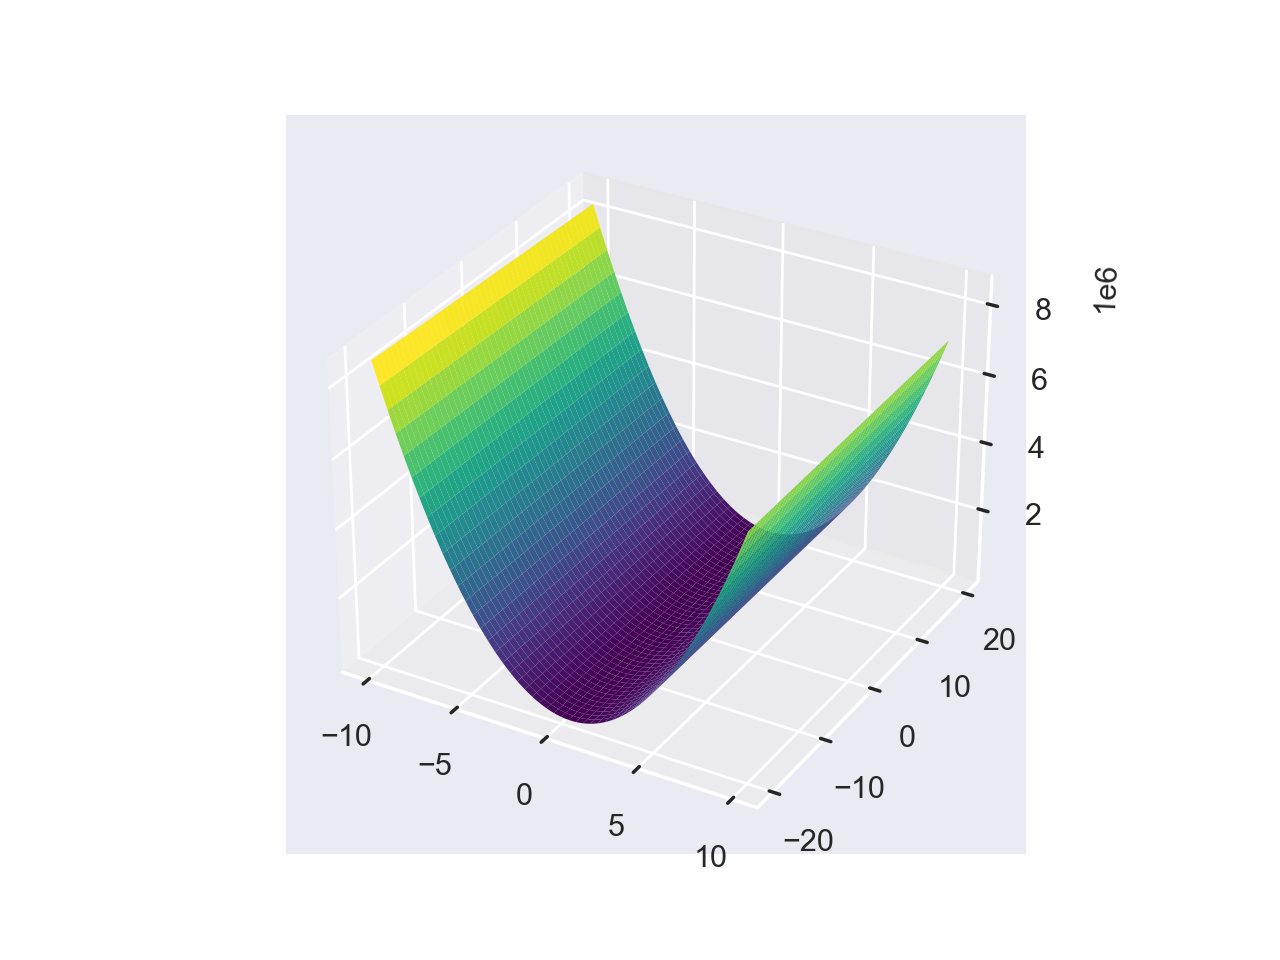

In [48]:
fig = plt.figure()
ax = plt.axes(projection='3d')
bs,ms = np.meshgrid(b_vec,m_vec)

# Create the SCATTER() plot with colors
ax.plot_surface(ms,bs, eval_mat, cmap='viridis',edgecolor='none');

## "Walking Down a Mountain"

Now that we have some intution for how gradient descent works very broadly, let's introduce the metaphor of walking down a mountain to introduce some new concepts. We can think of gradient descent like walking down a mountain (or hill) to a valley below. We are trying to find the lowest point in the valley in the most efficient manner possible, and we're starting from a relatively high point, so we ask ourselves: "what is the steepest way down?" (or more bluntly put, "what is the quickest way to fall to my death?"). If this is unclear, think of it this way: we can take the safe and gradual switchbacks down the mountain, but we'll get to the valley a lot faster if we just go straight down the steepest slope. Once we know the direction of the steepest way down, we take a big step in that direction, because we know we won't miss the lowest point in the valley if we take a big step when we're so high up. We repeat this process, taking smaller and smaller steps each time. This way, by the time we get to the valley and we're looking for the lowest point, we know we won't overstep and miss it. This has the unforunate effect of making our gradient descent algorithm take more iterations to reach the lowest point, because by the time we're near the lowest point in the valley, we're basically inching towards it.

Now that we have this metaphor for gradient descent, you might be wondering how we can implement this procedure algorithmically. How does an algorithm "start" somewhere on the "mountain"? How does an algorithm know the steepest way down, and how does an algorithm take smaller and smaller steps? I'll go through the answers to each of these questions below.

To begin our gradient descent, we intialize our m and b values to random values. The way we find the steepest way down the mountain is by computing the partial derivative of the MSE with respect to m and with respect to b at a certain point (the point on the mountain we are currently standing at). These partial derivatives will tell us the direction of greatest change, and give us functions to plug our current values of m and b into so we can determine how far to move in the m and b directions. We will subtract the derivatives from the current values of m and b. The size of our "steps" in gradient descent is the learning rate, which is the value we multiply the derivatives by so that we don't take too large of a step. We can adjust the learning rate after each iteration to take smaller and smaller steps if we want. Below is an equation for finding the new values of m and b using the derivatives of the MSE with respect to m and b, and using the learning rate L.

\begin{equation}
m_{new} = m - L*d_m(MSE) \\
b_{new} = b - L*d_b(MSE)
\end{equation}

## Coding Gradient Descent from Scratch

If you're a bit confused about how to actually implement the above algorithm, I will show a from-scratch implementation of how gradient descent works below. But first, we need to define some helper functions:

In [49]:
## Functions for later use
    
def compute_m_partial(in_vals, truth_vec, predict_vec):
    return -2*np.mean(in_vals*(truth_vec-predict_vec))

def compute_b_partial(truth_vec, predict_vec):
    return -2*np.mean(truth_vec-predict_vec)

def adjust_L(current_L, grad_step_num):
    # We can adjust this function however we want
    new_L = current_L * .95
    return new_L

In [73]:
def gradient_descent(n_steps, var1, var2, learning_rate, gradient_tolerance):
    # Initialize the max number of steps you wish to take
    max_steps = n_steps

    # Initialize starting parameters
    m = 3
    b = 0

    # Set a tolerance for the smallest you will allow 
    # the length of the gradient to be before stopping 
    grad_tol = gradient_tolerance

    # Create empty lists to store values for m, b, and the associated MSE
    outm = []
    outb = []
    outdm = []
    outdb = []
    outmse = []

    # Create an iterative process (ie. a loop) that will take N_STEPS
    for stp in range(max_steps):
        # For the current values of m and b: 
    
        # 1. Compute the MSE
        preds = m*var1 + b
        errormse = compute_mse(var2,preds)
    
        # 2. Store m, b, and the associated MSE in the output lists:
        outm.append(m)
        outb.append(b)
        outmse.append(errormse)
    
        # Update m and b by:
    
        # 1. Computing the gradient
        d_m = compute_m_partial(var1,var2,preds)
        d_b = compute_b_partial(var2, preds)
        
        outdm.append(d_m)
        outdb.append(d_b)
    
        # Compute the length of the gradient
        #norm_grad = np.linalg.norm()
        norm_grad = LA.norm([d_m, d_b])
    
        # If the length of the gradient is small enough, stop iterating
        if norm_grad < grad_tol:
            break
        
        # Update the values for m and b
        m = m - (learning_rate*d_m)
        b = b - (learning_rate*d_b)
    
        #Update learning rate
        #learning_rate = adjust_L(learning_rate, stp)
        
    return [outm[-1],outb[-1]], outm, outb, outdm, outdb

In [74]:
values = gradient_descent(100, weight, gestation, .00001, .001)
#values
print("final value for m is", values[0][0], "final value for b is", values[0][1])

final value for m is 2.291217256819553 final value for b is 0.004842404134455914


Some things you may have noticed in the above function: there is a max number of steps parameter, and a gradient tolerance. Also, you might be wondering what the gradient actually is in gradient descent.

In order for our gradient descent algorithm to know when to stop, we need to give it stopping conditions. If we didn't, it would just take small steps towards the optimal values of m and b forever. This is why we have the n_steps and gradient tolerance parameters. We can either tell our algorithm to stop after a certain number of iterations (steps) or when the gradient is too small. But again, what is the gradient? The gradient is just another term for the derivative of the MSE function. If the derivative/rate of change of the MSE function becomes really small, it's likely we've found values of m and b that are pretty close to optimal.

Below, I'm going to show a graph that visualizes how our gradient descent algorithm takes steps towards the optimal values of m and b (these optimal values have been computed using a separate function). This is why we were adding our values of m and b to a list in our gradient descent function. We did this so we could plot the values of m and b with each step the algorithm takes. The functions directly below this markdown block are helper functions for our plot.

In [75]:
# Coded by Katherine Kinnaird in CSC 294 Spring 2021
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color="lightblue")
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
def place_parameter(p_vec, col, ax=None):
    plt.scatter(p_vec[0],p_vec[1], c=col, marker = "*", s = 100)
    
def draw_parameter_path(p0,p1, col, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color=col)
    ax.annotate('', p1, p0, arrowprops=arrowprops) 

In [76]:
# Set up the particulars for the linear regression
lm_wt = linear_model.LinearRegression()

# Fit the linear regression to the data
model_wt = lm_wt.fit(gestation, weight)

# Extract the coefficients
m_wt = model_wt.coef_[0]
b_wt = model_wt.intercept_

<IPython.core.display.Javascript object>


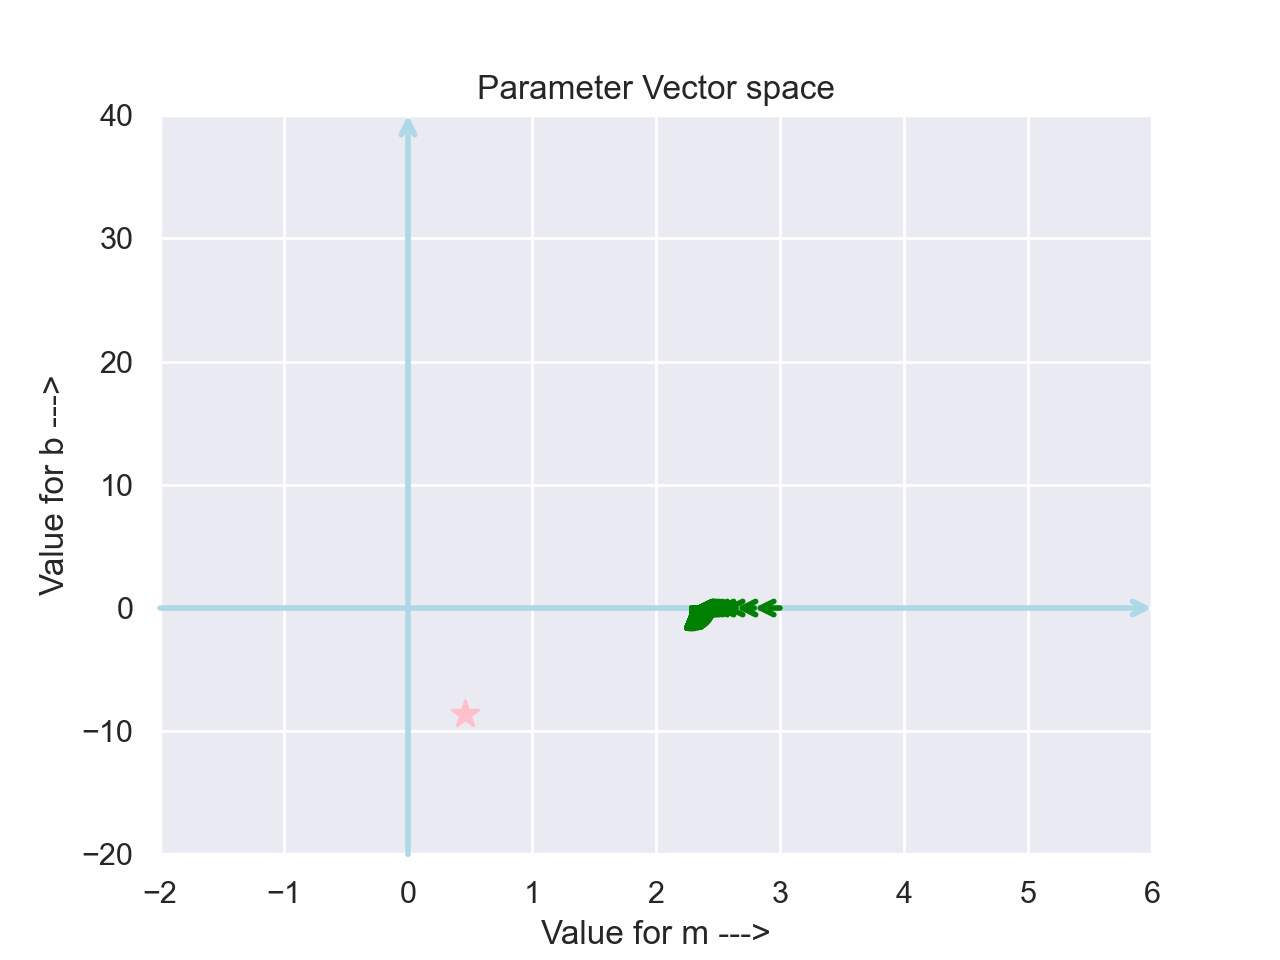

Text(0.5, 1.0, 'Parameter Vector space')

In [78]:
outm = values[1]
outb = values[2]
n_steps = 100

# Your plot of the path given by Gradient Descent
fig = plt.figure()

# Set axis limits
xmin = -2
xmax = max(outm) + 3
ymin = -20
ymax = max(outb) + 40

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Build axes
draw_vector([xmin,0], [xmax,0])
draw_vector([0,ymin], [0,ymax])

# Starting place 
#place_parameter([0,0],"red")

# plot vectors
for stp in range(n_steps - 1):
    draw_parameter_path([outm[stp], outb[stp]],[outm[stp+1],outb[stp+1]],"green")
    
# Linear regression m and b
place_parameter([m_wt,b_wt],"pink")

# Create grid and labels
plt.grid(True)
plt.xlabel('Value for m --->')
plt.ylabel('Value for b --->')
plt.title('Parameter Vector space')

It might be hard to see from the above plot, where I've plotted the position of the optimal values of m and b using a pink star, but the actual values of m and b are shown in the below code block

In [79]:
print(m_wt, b_wt)

[0.45895817] [-8.63312237]


Though we can see the gradient descent algorithm taking steps towards the appropriate parameters in this case, the b value is barely changing from it's original value. It is worth noting that though this same function has been validated and has worked on a different dataset, there could be something wrong with our function. Let's take a look at how the d_m and d_b values change:

<IPython.core.display.Javascript object>


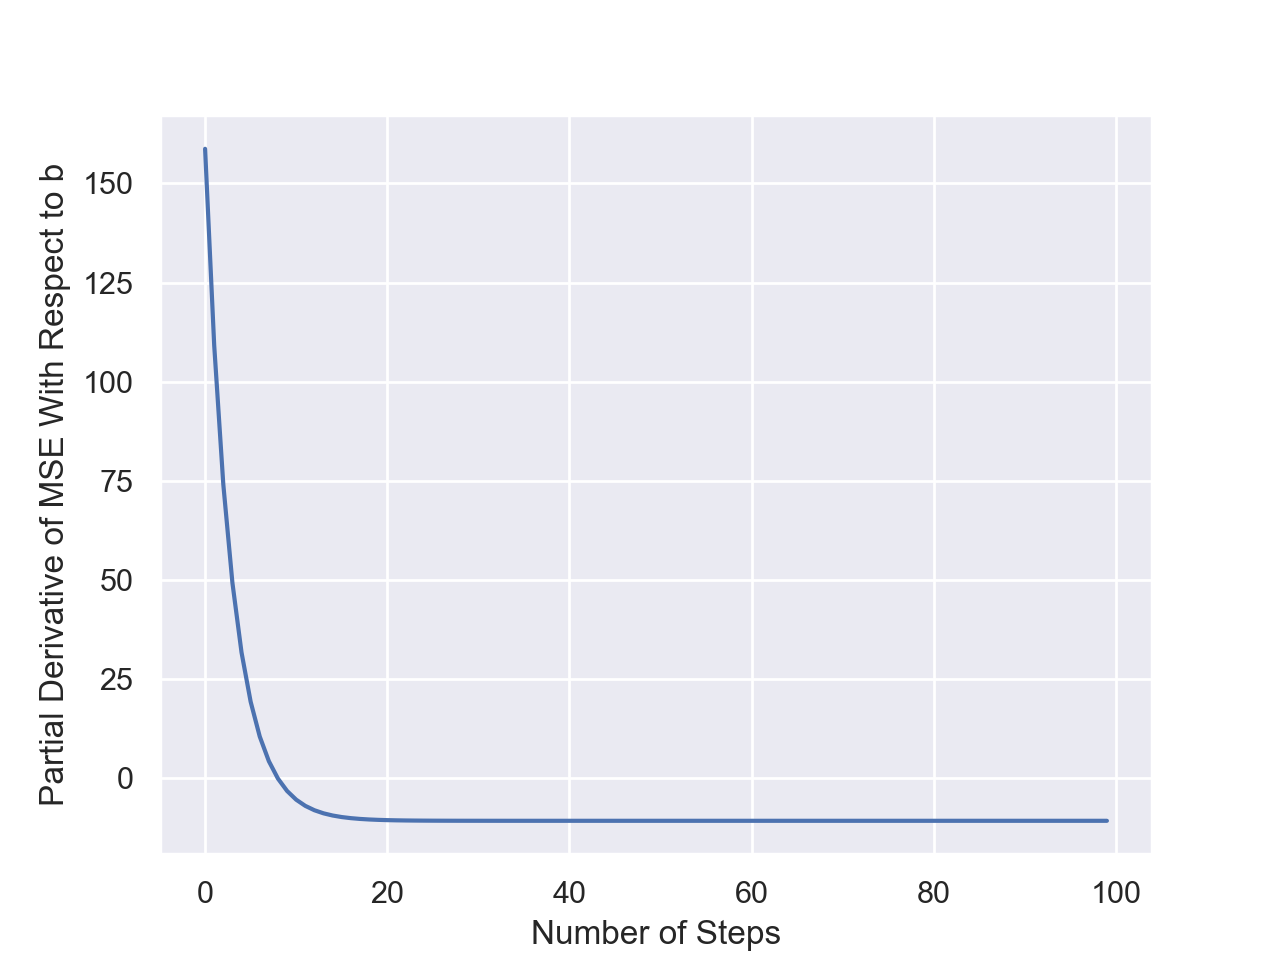

Text(0, 0.5, 'Partial Derivative of MSE With Respect to b')

In [80]:
outdm = values[3]
outdb = values[4]

plt.plot(range(0, 100), outdb)
plt.xlabel("Number of Steps")
plt.ylabel("Partial Derivative of MSE With Respect to b")

<IPython.core.display.Javascript object>


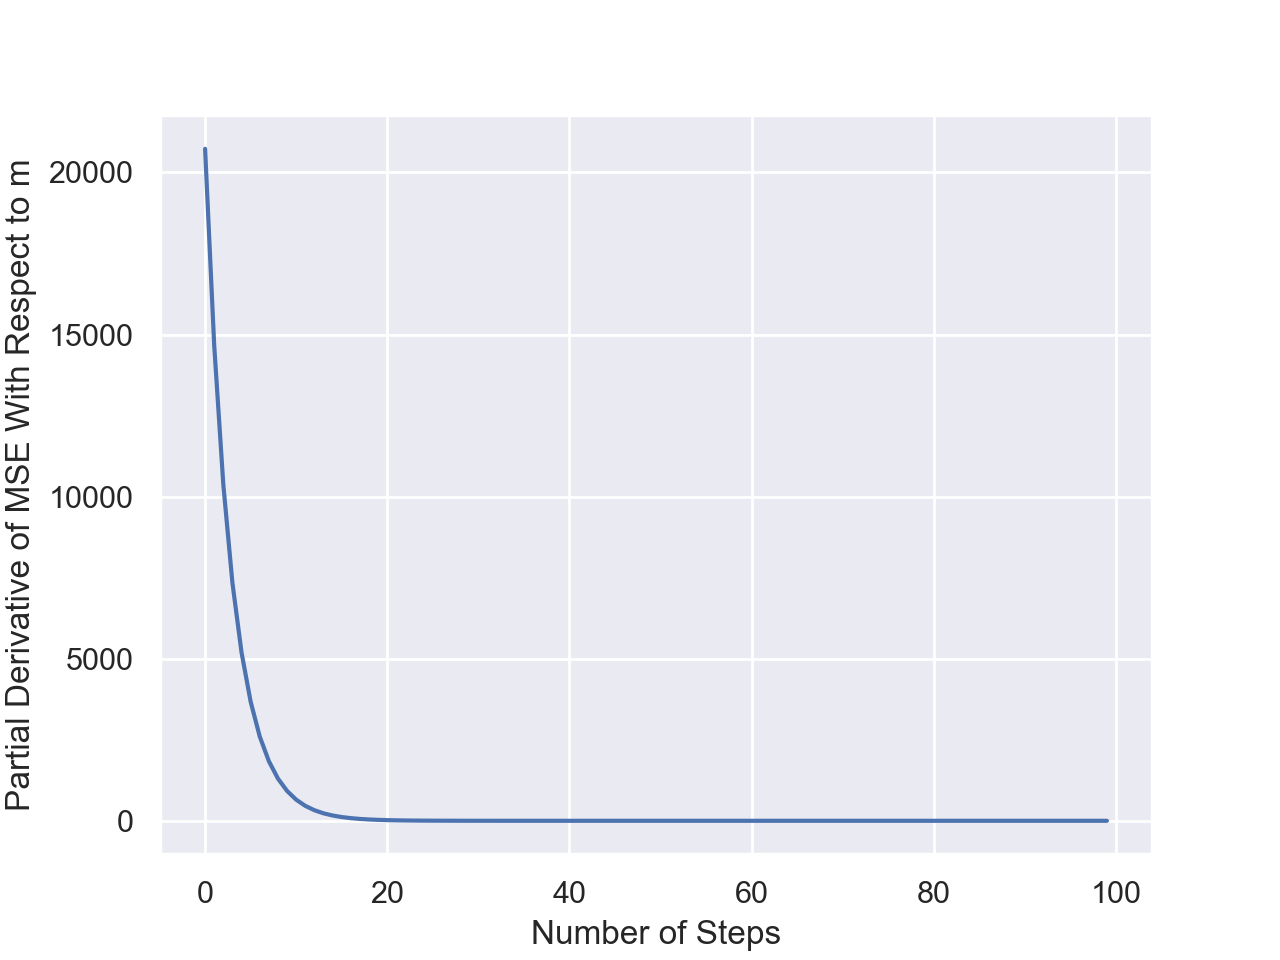

Text(0, 0.5, 'Partial Derivative of MSE With Respect to m')

In [81]:
plt.plot(range(0, 100), outdm)
plt.xlabel("Number of Steps")
plt.ylabel("Partial Derivative of MSE With Respect to m")

It looks like our d_b is changing in a similar way to our d_m, so it's likely that this is not the issue with our function. Due to time constraints, I unfortunately cannot figure out why this gradient descent algorithm is performing poorly on this data set, I can only speculate possible issues. It's possible that because the MSE for the b parameter looks to be roughly the same everywhere where the m value is close to zero, our algorithm is getting stuck. This is something we can see in the surface above. There's a very flat bottom, that could perhaps have a very subtle and hard to find lowest point, but I can't say this is the issue for sure. Additionally, in order for this gradient descent algorithm to not swing wildly between positive and negative values and inflate like crazy, the learning rate had to be very small, so our algorithm doesn't get us very far. This is definitely strange, and something worth investigating in the future. It's possible this data could benefit from a more advanced gradient descent algorithm, but I can't know for sure without more investigation.

## Other Types of Gradient Descent

The above type of gradient descent can get very time-consuming and inefficient, because it is performing computations using the entire data set with every iteration. This is where more cost-effective alternatives come in like stochastic gradient descent and mini-batch gradient descent. Stochastic gradient descent uses just one point for computing the MSE instead of the whole data set, while mini-batch gradient descent uses a "batch" or number of points that is smaller than the size of the original data set.

In [60]:
def stochastic_gd(n_steps, data, learning_rate, gradient_tolerance):
    ## This implementation takes a numpy multi-dimensional array with explanatory variable as
    ## column 1 and response variable as column 2 for data shuffling purposes

    # Initialize starting parameters
    m = 0
    b = 0

    # Create empty lists to store values for m, b, and the associated MSE
    outm = []
    outb = []
    outmse = []

    # Create an iterative process (ie. a loop) that will take N_STEPS
    for stp in range(n_steps):
        
        # shuffle data
        np.random.shuffle(data)
        
        # For the current values of m and b: 
    
        # 1. Compute the MSE
        rand_ind = np.random.choice(data.shape[0], size=1)
        preds = m*data[:, 0][rand_ind] + b
        errormse = compute_mse(data[:, 1][rand_ind],preds)
    
        # 2. Store m, b, and the associated MSE in the output lists:
        outm.append(m)
        outb.append(b)
        outmse.append(errormse)
    
        # Update m and b by:
        
        # 1. Computing the gradient
        d_m = compute_m_partial(data[:, 0][rand_ind], data[:, 1][rand_ind],preds)
        d_b = compute_b_partial(data[:, 1][rand_ind], preds)
    
        
        # Update the values for m and b
        m = m - (learning_rate*d_m)
        b = b - (learning_rate*d_b)
    
        # Update learning rate
        learning_rate = adjust_L(learning_rate, stp)
        
    return [outm[-1], outb[-1]], outm, outb

In [61]:
values_stochastic = stochastic_gd(100, babies_gw, .00001, 1)
print("stochastic final value for m is", values_stochastic[0][0], 
      "\nstochastic final value for b is", values_stochastic[0][1])

stochastic final value for m is 0.42627017853006005 
stochastic final value for b is 0.0015005440540054836


<IPython.core.display.Javascript object>


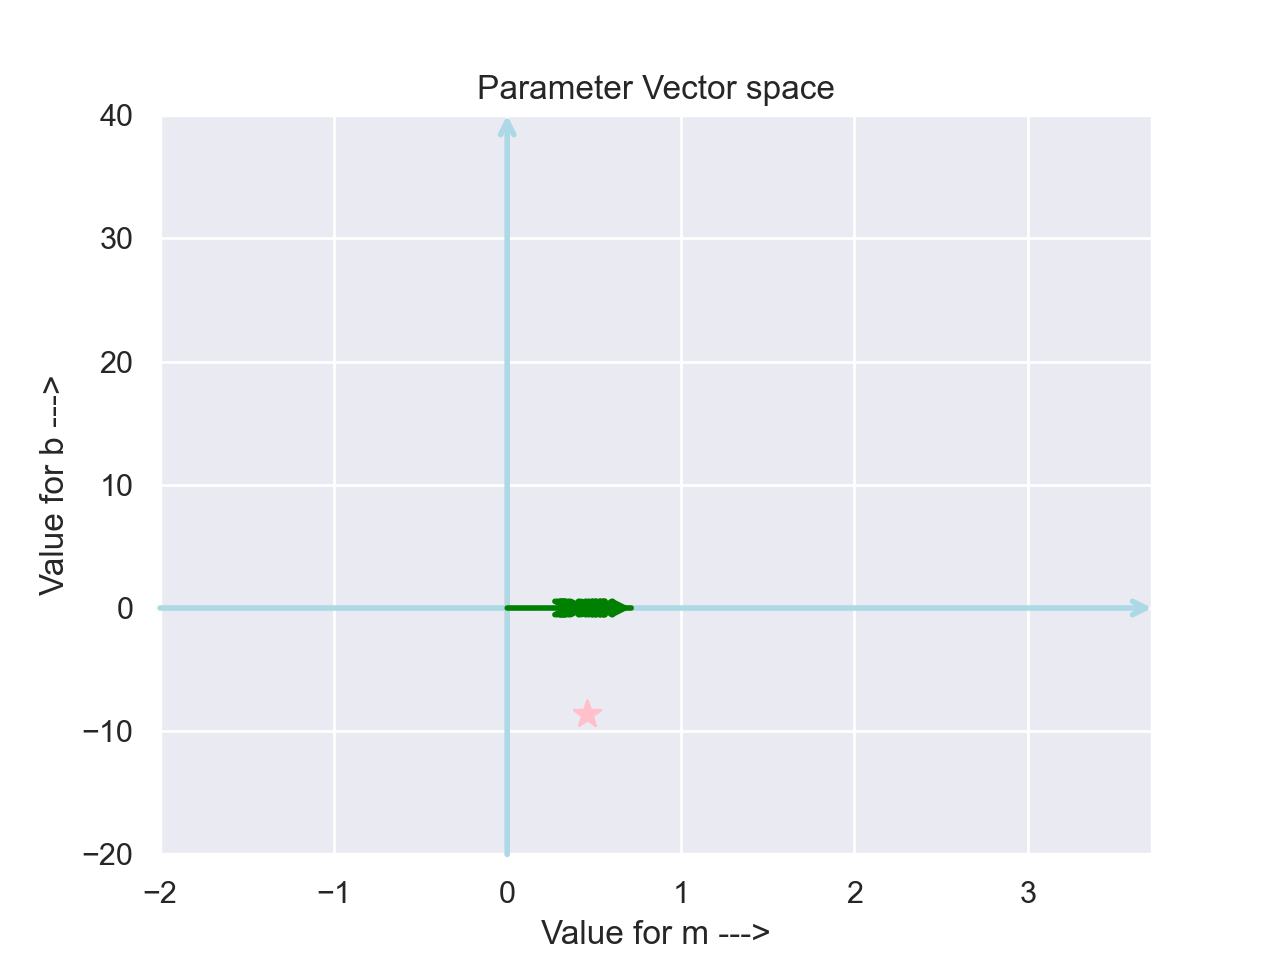

Text(0.5, 1.0, 'Parameter Vector space')

In [63]:
outm1 = values_stochastic[1]
outb1 = values_stochastic[2]
n_steps = 50

# Your plot of the path given by Gradient Descent
fig = plt.figure()

# Set axis limits
xmin = -2
xmax = max(outm1) + 3
ymin = -20
ymax = max(outb1) + 40

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Build axes
draw_vector([xmin,0], [xmax,0])
draw_vector([0,ymin], [0,ymax])

# Starting place 
#place_parameter([0,0],"red")

# plot vectors
for stp in range(n_steps - 1):
    draw_parameter_path([outm1[stp], outb1[stp]],[outm1[stp+1],outb1[stp+1]],"green")
    
# Linear regression m and b
place_parameter([m_wt,b_wt],"pink")

# Create grid and labels
plt.grid(True)
plt.xlabel('Value for m --->')
plt.ylabel('Value for b --->')
plt.title('Parameter Vector space')

Though we can see this stochastic gradient descent algorithm still doesn't perform amazingly well on the dataset, it can give us an idea of how stochastic gradient descent works (I've again indicated the position of the optimal values of m and b with a pink star).

## How Does This Implementation Stack Up?

We can compare our stochastic gradient descent to sklearn's implementation, called "SGDRegressor":

In [64]:
sgd = linear_model.SGDRegressor(max_iter = 500, tol = .01, learning_rate = 'constant', alpha = .00001)
mod = sgd.fit(weight, np.ravel(weight))

print("final m is", mod.coef_, "final b is", mod.intercept_)

final m is [2.69226002e+11] final b is [-3.00676873e+10]


It looks like sklearn's stochastic gradient descent implementation doesn't do much better than ours at moving towards the appropriate values of m and b, as we can see that it returns huge numbers for the final values of m and b after 500 iterations/steps. This feels oddly validating considering how seemingly poorly the from-scratch implementations of gradient descent have been performing on this dataset, but again, I'm not sure why this poor performance is occurring.

In [65]:
%%timeit

stochastic = stochastic_gd(500, babies_gw, .00001, 1)

873 ms ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%timeit

sgd = linear_model.SGDRegressor(max_iter = 500, tol = 1, learning_rate = 'constant', alpha = .00001)
mod = sgd.fit(weight, np.ravel(weight))

915 µs ± 76.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%load_ext memory_profiler

In [67]:
%memit

stochastic = stochastic_gd(500, babies_gw, .00001, 1)

peak memory: 310.48 MiB, increment: 0.00 MiB


In [68]:
%memit

sgd = linear_model.SGDRegressor(max_iter = 500, tol = 1, learning_rate = 'constant', alpha = .00001)
mod = sgd.fit(weight, np.ravel(weight))

peak memory: 310.48 MiB, increment: 0.00 MiB


We can see that the sklearn implementation for stochastic gradient descent is lightning fast compared to the one I coded from scratch. The measures of time taken for each implementation are not even in the same units, as the sklearn implementation was measured in microseconds, while my implementation was measured in milliseconds. It does look like the two implementations use similar amounts of memory though, so it looks like one isn't more efficent than the other in that regard.

## Using Gradient Descent for Interaction Models

What if we wanted to use gradient descent for regression lines in which we have more than one explanatory variable, and in which there is an interaction term? We can do this too. The equation for a basic interaction model with two explanatory variables can be written as follows:

\begin{equation}
\widehat{response} = b + m1*x_{1} + m2*x_{2} + m3*(x_{1}*x_{2})
\end{equation}

For this implementation, we'll be using the age and smoke variables from the babies dataset to prevent overflow errors in our gradient descent.

In [82]:
# Prepare the data
babies_interaction = babies_wrangled.copy()
babies_interaction["age*smoke"] = babies_interaction["smoke"]*babies_interaction["smoke"]
babies_int_np = babies_interaction.loc[:, ["age", "smoke", "age*smoke", "wt"]].to_numpy()

Below is an implementation of from-scratch interaction model gradient descent. Notice how similar it is to vanilla gradient descent. The only thing we've changed here is that we're using two explanatory variables with interaction.

In [70]:
def interaction_gd(n_steps, var1, var2, response, learning_rate, gradient_tolerance):
    ## Only takes two explanatory variables

    # Initialize starting parameters
    m1 = 0
    m2 = 0
    m3 = 0
    b = 0

    # Set a tolerance for the smallest you will allow 
    # the length of the gradient to be before stopping 
    grad_tol = gradient_tolerance

    # Create empty lists to store values for m, b, and the associated MSE
    outm1 = []
    outm2 = []
    outm3 = []
    outb = []
    outmse = []

    # Create an iterative process (ie. a loop) that will take N_STEPS
    for stp in range(n_steps):
        # For the current values of m and b: 
    
        # 1. Compute the MSE
        preds = m1*var1 + m2*var2 + m3*var1*var2 + b
        errormse = compute_mse(response,preds)
    
        # 2. Store m, b, and the associated MSE in the output lists:
        outm1.append(m1)
        outm2.append(m2)
        outm3.append(m3)
        outb.append(b)
        outmse.append(errormse)
    
        # Update m and b by:
    
        # 1. Computing the gradient
        d_m1 = compute_m_partial(var1,response,preds)
        d_m2 = compute_m_partial(var2,response,preds)
        d_m3 = compute_m_partial(np.multiply(var1, var2),response,preds)
        d_b = compute_b_partial(response, preds)
    
        # Compute the length of the gradient
        #norm_grad = LA.norm([d_m1, d_b1])
    
        # If the length of the gradient is small enough, stop iterating
        #if norm_grad < grad_tol:
            #break
        
        # Update the values for m and b
        m1 = m1 - (learning_rate*d_m1)
        m2 = m2 - (learning_rate*d_m2)
        m3 = m3 - (learning_rate*d_m3)
        b = b - (learning_rate*d_b)
    
        # Update learning rate
        #L = adjust_L(L, stp)
        
    return [outm1[-1], outm2[-1], outm3[-1], outb[-1]], outm1, outm2, outm3, outb

In [71]:
val_int = interaction_gd(100, babies_int_np[0], babies_int_np[1], babies_int_np[3], .00000001, 1)
print("final slope coefficient for age is", val_int[0][0], 
      "\nfinal slope coefficient for smoke is", val_int[0][1],
      "\nfinal slope coefficient for age*smoke is", val_int[0][2],
      "\nfinal intercept coefficient for equation is", val_int[0][3])

final slope coefficient for age is 0.00022163141823452288 
final slope coefficient for smoke is 0.0002683463447362269 
final slope coefficient for age*smoke is 0.008037115944827075 
final intercept coefficient for equation is 8.939056479770608e-06


In [72]:
# Create interaction model
lm_int = linear_model.LinearRegression()
model_int = lm_int.fit(babies_int_np[:, 0:3], babies_int_np[:, 3])
print("true slope coefficient for age is", model_int.coef_[0], 
"\ntrue slope coefficient for smoke is", model_int.coef_[1],
"\ntrue slope coefficient for age*smoke is", model_int.coef_[2],
"\ntrue intercept coefficient for equation is", model_int.intercept_)

true slope coefficient for age is 0.012669152459974702 
true slope coefficient for smoke is -11.49227643302591 
true slope coefficient for age*smoke is 4.302303069842204 
true intercept coefficient for equation is 122.1445362675215


After computing the true coefficient values (using sklearn's linear regression algorithm) in the above code block, and after computing the coefficient values using the interaction model gradient descent algorithm in the code block above that, we can see that again, this implementation doesn't perform amazingly well on the data (for reasons I'm not entirely sure of). However, we can see that the algorithm is mostly moving towards the appropriate coefficient values.

## Conclusion

Though none of the gradient descent algorithms employed were able to get close to the true values of the slope and intercept coefficients for this particular data set, this does not mean that gradient descent cannot be useful in other contexts. There was simply not enough time for me to find the root of why my algorithms were not performing well on this data set. Regardless, hopefully this notebook was informative for explaining the concept of gradient descent (and its many flavors), and hopefully you think gradient descent is as cool as I think it is!

### Resources Used:

1. Lab 9 from Katherine Kinnaird's Spring 2021 Machine Learning course (CSC 294)
2. Lab 10 from Katherine Kinnaird's Spring 2021 Machine Learning course (CSC 294)
1. Lab 11 from Katherine Kinnaird's Spring 2021 Machine Learning course (CSC 294)